In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 

from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image

from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [2]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'
# loading up our datasets
train_data_dir = 'base_data/train'
validation_data_dir = 'base_data/validation'
test_data_dir = 'base_data/test'
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

In [10]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)

Found 243 images belonging to 3 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
Time: 0:18:49.186531


In [4]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_validation_samples = len(generator.filenames) 
num_classes1 = len(generator.class_indices) 
 
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
 
bottleneck_features_validation = vgg16.predict_generator(generator, predict_size_validation) 
 
np.save('bottleneck_features_validation1.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)

Found 26 images belonging to 3 classes.


C:\Users\Code\Anaconda3\envs\raja_dl\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time: 0:00:02.491705


In [5]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_test = int(math.ceil(nb_test_samples / batch_size)) 
 
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test) 
 
np.save('bottleneck_features_test1.npy', bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time:', elapsed)

Found 11 images belonging to 3 classes.
Time: 0:00:01.008626


In [6]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 243 images belonging to 3 classes.


In [7]:
#Validation data
generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_validation_samples = len(generator_top.filenames) 
num_classes1 = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load('bottleneck_features_validation.npy') 
 
# get the class labels for the training data, in the original order 
validation_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes1)

Found 26 images belonging to 3 classes.


In [8]:
#Test data
generator_top = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_test_samples = len(generator_top.filenames) 
num_classes2 = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load('bottleneck_features_test.npy') 
 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes2)

Found 11 images belonging to 3 classes.


In [9]:
start = datetime.datetime.now()

model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

history = model.fit(train_data, train_labels,epochs=7,batch_size=batch_size,validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size=batch_size,verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time:' , elapsed)

Epoch 1/7
5/5 [==============================] - 2s 319ms/step - loss: 1.3934 - acc: 0.4227 - val_loss: 1.1803 - val_acc: 0.3462
Epoch 2/7
5/5 [==============================] - 0s 31ms/step - loss: 1.0663 - acc: 0.4883 - val_loss: 1.0576 - val_acc: 0.3846
Epoch 3/7
5/5 [==============================] - 0s 31ms/step - loss: 0.9986 - acc: 0.4812 - val_loss: 1.0186 - val_acc: 0.4615
Epoch 4/7
5/5 [==============================] - 0s 30ms/step - loss: 0.7914 - acc: 0.6453 - val_loss: 1.0091 - val_acc: 0.6154
Epoch 5/7
5/5 [==============================] - 0s 29ms/step - loss: 0.7080 - acc: 0.6732 - val_loss: 1.2557 - val_acc: 0.4231
Epoch 6/7
5/5 [==============================] - 0s 31ms/step - loss: 0.7376 - acc: 0.6677 - val_loss: 1.0156 - val_acc: 0.5385
Epoch 7/7
1/1 [==============================] - 0s 0s/step - loss: 1.0836 - acc: 0.4615
[INFO] accuracy: 46.15%
[INFO] Loss: 1.0836272239685059
Time: 0:00:03.064751


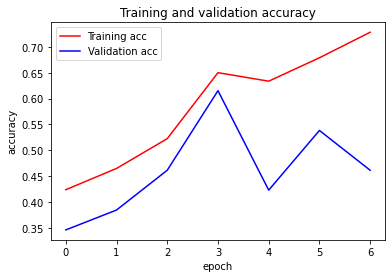

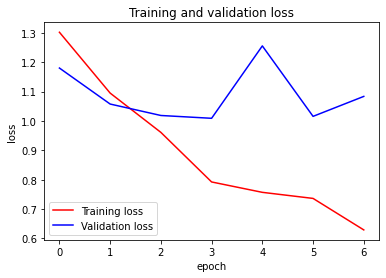

In [10]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [11]:
model.evaluate(test_data,test_labels)

1/1 [==============================] - 0s 13ms/step - loss: 0.9566 - acc: 0.5455


[0.956646203994751, 0.5454545617103577]

In [12]:
preds=np.round(model.predict(test_data),0)
print('rounded test_labes',preds)

rounded test_labes [[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]


In [13]:
emotion=['amusement','anger','awe']
classification_metrics=metrics.classification_report(test_labels,preds,target_names=emotion)
print(classification_metrics)

              precision    recall  f1-score   support

   amusement       0.67      0.67      0.67         3
       anger       0.50      0.33      0.40         3
         awe       1.00      0.20      0.33         5

   micro avg       0.67      0.36      0.47        11
   macro avg       0.72      0.40      0.47        11
weighted avg       0.77      0.36      0.44        11
 samples avg       0.36      0.36      0.36        11



C:\Users\Code\Anaconda3\envs\raja_dl\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
#Add Normalization Option
 #prints pretty confusion metric with normalization option ‘’’
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
# print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

Normalized confusion matrix


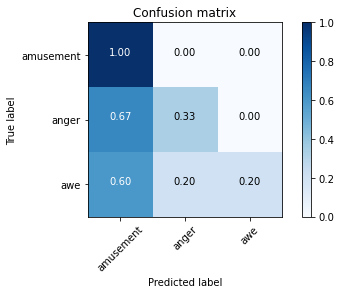

In [15]:
plot_confusion_matrix(confusion_matrix,['amusement','anger','awe'],normalize=True)

[INFO] loading and preprocessing image…


C:\Users\Code\Anaconda3\envs\raja_dl\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


ID: 0, Label: amusement 21.67%
ID: 1, Label: anger 38.95%
ID: 2, Label: awe 39.38%
Final Decision:
.
..
...
ID:2,Label:awe


C:\Users\Code\Anaconda3\envs\raja_dl\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


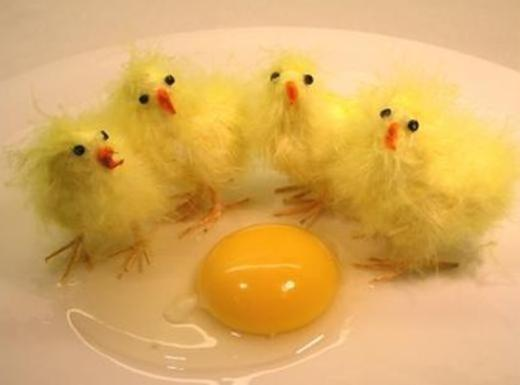

In [18]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image…") 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image

def test_single_image(path):
    animals = ['amusement', 'anger','awe']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
        
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("ID:{},Label:{}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
    
    return load_img(path)
path = 'C:/Users/Code/Desktop/ME/Multiclass Image Classification/base_data/test/amusement/amusement_0732.jpg'
test_single_image(path)

In [169]:
(eval_loss, eval_accuracy) = model.evaluate(test_data, test_labels, batch_size=batch_size,verbose=1)
predicted_label=model.predict(test_data)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time:' , elapsed)

predicted_label
np.argmax(predicted_label)

1/1 [==============================] - 0s 14ms/step - loss: 0.9566 - acc: 0.5455
[INFO] accuracy: 54.55%
[INFO] Loss: 0.956646203994751
Time: 2:34:43.640213


0

[INFO] loading and preprocessing image…
ID: 0, Label: amusement 21.67%
ID: 1, Label: anger 38.95%
ID: 2, Label: awe 39.38%
Final Decision:
.
..
...
ID:2,Label:awe


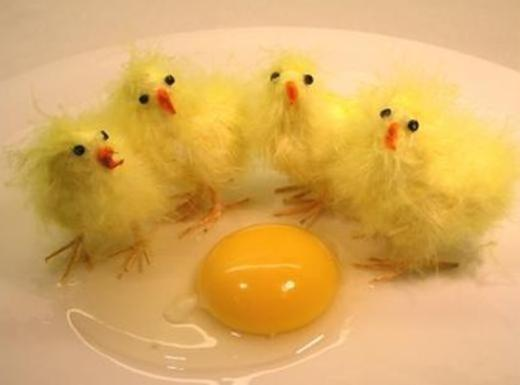

In [107]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image…") 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image

def test_single_image(path):
    animals = ['amusement', 'anger','awe']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
        
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("ID:{},Label:{}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
    
    return load_img(path)


path = 'C:/Users/Code/Desktop/ME/Multiclass Image Classification/base_data/test/amusement/amusement_0732.jpg'
test_single_image(path)




Actual Image:C:/Users/Code/Desktop/ME/Multiclass Image Classification/base_data/test/amusement/amusement_0544.jpg
ID: 0, Label: amusement 81.0%
ID: 1, Label: anger 9.7%
ID: 2, Label: awe 9.3%
Final Decision:
.
..
...
Top Score ID Number is:0,Predicted Label is:amusement
Actual Image:C:/Users/Code/Desktop/ME/Multiclass Image Classification/base_data/test/amusement/amusement_0717.jpg
ID: 0, Label: amusement 55.25%
ID: 1, Label: anger 25.31%
ID: 2, Label: awe 19.44%
Final Decision:
.
..
...
Top Score ID Number is:0,Predicted Label is:amusement
Actual Image:C:/Users/Code/Desktop/ME/Multiclass Image Classification/base_data/test/amusement/amusement_0732.jpg
ID: 0, Label: amusement 21.67%
ID: 1, Label: anger 38.95%
ID: 2, Label: awe 39.38%
Final Decision:
.
..
...
Top Score ID Number is:2,Predicted Label is:awe


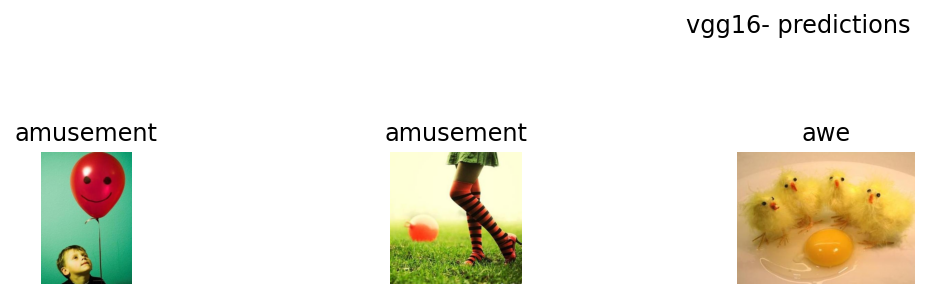

In [167]:
def read_image(file_path):
    print("Actual Image:"+file_path) 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image


import os
import matplotlib.pyplot as plt
import matplotlib.image as mping
train_dir=os.path.join('C:/Users/Code/Desktop/ME/Multiclass Image Classification/base_data/test/amusement/')
train = os.listdir(train_dir)
fname1 = [os.path.join(train_dir,fname)
        for fname in train[:]]


plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.9)
plt.subplots_adjust(wspace=0.9)
plt.subplots_adjust(bottom=0.1)
plt.subplots_adjust(top=0.9)
plt.subplots_adjust(right=0.9)
plt.subplots_adjust(left=0.125)
for i,fname in enumerate(fname1):
    img = mping.imread(fname)
    sp = plt.subplot(6,5,i+1)
    sp.axis('off')
    animals = ['amusement', 'anger','awe']
    images = read_image(fname)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
        
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("Top Score ID Number is:{},Predicted Label is:{}".format(class_predicted[0],inv_map[class_predicted[0]])) 

    plt.title(inv_map[class_predicted[0]])
    plt.imshow(img)
    plt.suptitle("vgg16- predictions")
plt.show()

Actual Image:C:/Users/Code/Desktop/ME/Multiclass Image Classification/all_test/amusement_0503.jpg
ID: 0, Label: amusement 55.75%
ID: 1, Label: anger 25.96%
ID: 2, Label: awe 18.3%
Final Decision:
.
..
...
Top Score ID Number is:0,Predicted Label is:amusement
Actual Image:C:/Users/Code/Desktop/ME/Multiclass Image Classification/all_test/amusement_0513.jpg
ID: 0, Label: amusement 76.71%
ID: 1, Label: anger 7.07%
ID: 2, Label: awe 16.22%
Final Decision:
.
..
...
Top Score ID Number is:0,Predicted Label is:amusement
Actual Image:C:/Users/Code/Desktop/ME/Multiclass Image Classification/all_test/amusement_0544.jpg
ID: 0, Label: amusement 81.0%
ID: 1, Label: anger 9.7%
ID: 2, Label: awe 9.3%
Final Decision:
.
..
...
Top Score ID Number is:0,Predicted Label is:amusement
Actual Image:C:/Users/Code/Desktop/ME/Multiclass Image Classification/all_test/amusement_0717.jpg
ID: 0, Label: amusement 55.25%
ID: 1, Label: anger 25.31%
ID: 2, Label: awe 19.44%
Final Decision:
.
..
...
Top Score ID Number i

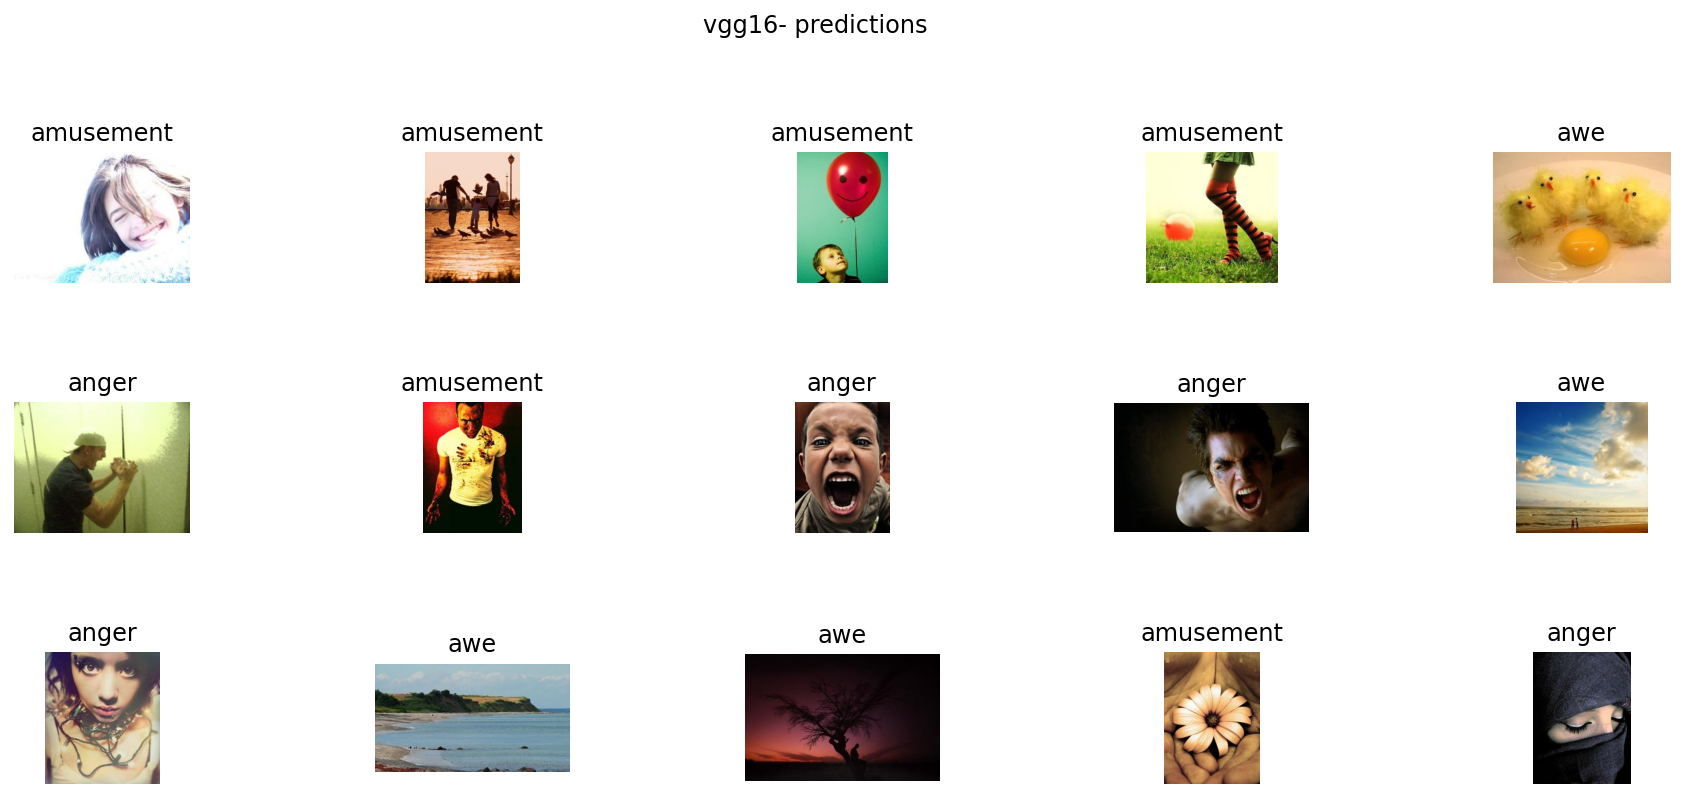

In [165]:
def read_image(file_path):
    print("Actual Image:"+file_path) 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image


import os
import matplotlib.pyplot as plt
import matplotlib.image as mping
train_dir=os.path.join('C:/Users/Code/Desktop/ME/Multiclass Image Classification/all_test/')
#validate_dir= os.path.join('base_data/test/amusement')

train = os.listdir(train_dir)
fname1 = [os.path.join(train_dir,fname)
        for fname in train[:]]


plt.figure(figsize=(15,12))
plt.subplots_adjust(hspace=0.9)
plt.subplots_adjust(wspace=0.9)
plt.subplots_adjust(bottom=0.1)
plt.subplots_adjust(top=0.9)
plt.subplots_adjust(right=0.9)
plt.subplots_adjust(left=0.125)
for i,fname in enumerate(fname1):
    img = mping.imread(fname)
    sp = plt.subplot(6,5,i+1)
    sp.axis('off')
    animals = ['amusement', 'anger','awe']
    images = read_image(fname)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
        
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("Top Score ID Number is:{},Predicted Label is:{}".format(class_predicted[0],inv_map[class_predicted[0]])) 

    plt.title(inv_map[class_predicted[0]])
    plt.imshow(img)
    plt.suptitle("vgg16- predictions")
plt.show()